# Reversal learning task

Probability ratings will be used to derive both model-free and model-based parameters that will describe the quality of learning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import warnings
warnings.filterwarnings('ignore')

### get data and age

In [3]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    temp = pd.read_csv(sub)
    temp['sub']= sub.split("_")[2]
    temp['CSp'] = temp.rectOri[2]
    db = db.append(temp)

In [4]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans')


In [5]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans')
age = age.iloc[:,1:8:6]
age.rename(columns={age.columns[0]: "sub" }, inplace = True)
age['sub'] = age['sub'].map(lambda x: x.lstrip('AG_'))

age = age.dropna()
age = age.drop_duplicates('sub')
db = db.merge(age, left_on='sub', right_on='sub')

trials with no response get rating of 0. 

here we replace it with NaN as 0 looks like a very low rating

In [6]:
db['rating_clean'] = db.rating
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

plot with 0s

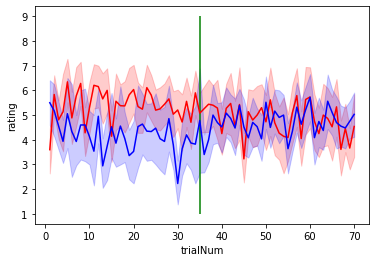

In [7]:
sns.lineplot(x = 'trialNum', y = 'rating', data=db[(db.rectOri == db.CSp)], color = 'red')
sns.lineplot(x = 'trialNum', y = 'rating', data=db[(db.rectOri != db.CSp)], color = 'blue')
plt.vlines(x = 35, ymin = 1, ymax = 9, colors = 'green')

plot without 0s

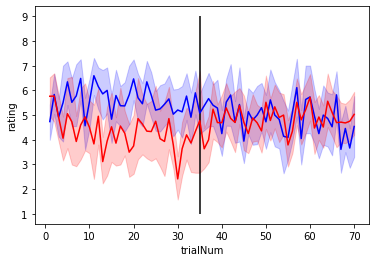

In [8]:
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

overall disterbution of responses

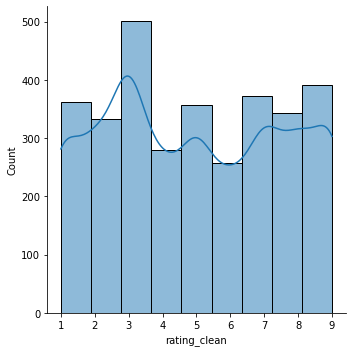

In [9]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late reversal and late acquisition


In [10]:
subs = db['sub'].unique()

model_free= pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSpA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSmA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    
    CSpeR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])
    CSmeR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])

    CSpR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSmR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSpA - CSmA
    dCSp = CSpA - CSpR 
    dCSm = CSmR - CSmA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ':[ACQ], 'dCSp':[dCSp], 'dCSm':[dCSm], 
                         'age':[df.Age[0]], 'CSpR':[CSpR], 'CSpeR': [CSpeR],
                        'CSmeR':[CSmeR], 'CSmR':[CSmR]})
    model_free = model_free.append(temp)

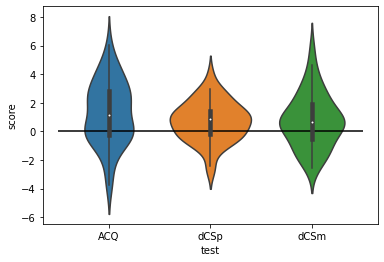

In [11]:
fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'dCSp', 'dCSm'], value_name='score', var_name = 'test')
sns.violinplot(x = 'test', y='score', data=fig2)

plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

In [12]:
ACQ_cor = sp.stats.pearsonr(model_free.ACQ, model_free.age)
dCSp_cor = sp.stats.pearsonr(model_free.dCSp, model_free.age)
dCSM_cor = sp.stats.pearsonr(model_free.dCSm, model_free.age)

print('ACQ * Age: ', ACQ_cor, 'dCSp * Age: ', dCSp_cor, 'dCSm * Age: ', dCSM_cor)

ACQ * Age:  (-0.305910053321041, 0.03868346521528899) dCSp * Age:  (-0.32244461207479663, 0.02885349787723402) dCSm * Age:  (-0.35939054892693856, 0.014167168544576014)


[Text(0, 0.5, '')]

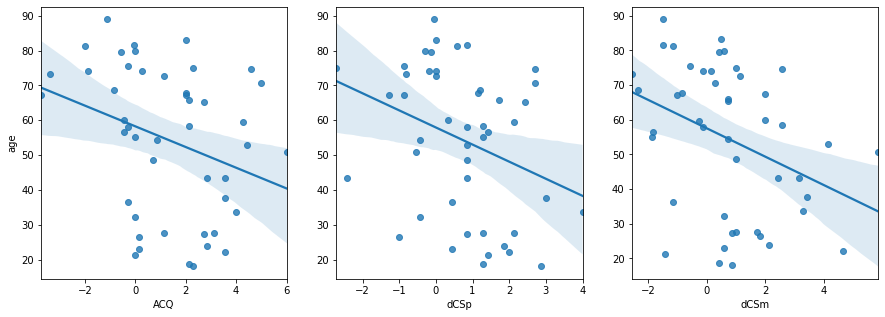

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(x = 'ACQ',  y = 'age', data=model_free, ax=axes[0])
sns.regplot(x = 'dCSp', y = 'age', data=model_free, ax=axes[1])
sns.regplot(x = 'dCSm', y = 'age', data=model_free, ax=axes[2])
axes[1].set(ylabel=None)
axes[2].set(ylabel=None)

In [14]:
fig3 = pd.melt(model_free, id_vars=['sub','age'], value_vars=['CSpR', 'CSpeR', 'CSmeR', 'CSmR'], value_name='score', var_name = 'test')

norm = matplotlib.colors.Normalize(vmin=fig3["age"].min(), vmax=fig3["age"].max())
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in fig3["age"]:
    colors.update({cval : cmap(norm(cval))})
    
x = np.arange(0, 10, .5)
y = x

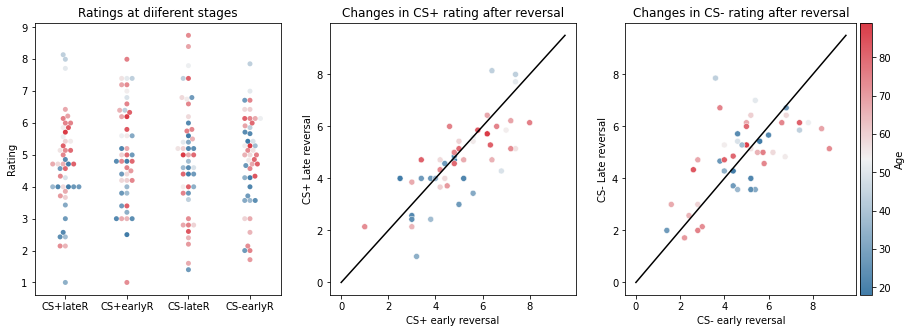

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.swarmplot(x = 'test', y = 'score', hue = 'age', palette = colors, data = fig3, ax=axes[0])
sns.scatterplot(x = 'CSpeR', y = 'CSpR', hue = 'age', palette = colors, data = model_free, ax = axes[1])
sns.scatterplot(x = 'CSmeR', y = 'CSmR', hue = 'age', palette = colors, data = model_free, ax = axes[2])

axes[0].legend_.remove()
axes[0].set(xlabel=None, ylabel='Rating', title='Ratings at diiferent stages', 
            xticklabels=['CS+lateR','CS+earlyR','CS-lateR','CS-earlyR'])

axes[1].set(xlabel='CS+ early reversal', ylabel='CS+ Late reversal', 
            title='Changes in CS+ rating after reversal')
axes[2].set(xlabel='CS- early reversal', ylabel='CS- Late reversal', 
            title='Changes in CS- rating after reversal')

for ax in axes[1:]:
    ax.plot(y, x, C='k')
    ax.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()